# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [1]:
# Header
from __future__ import print_function

import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"


path = '/home/ubuntu/data/training/text/quijote/'

Tensorflow version:  1.2.1


## Download data and generate sequences

Download quijote from guttenberg project

wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [2]:
#Read book
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

# Simplify text to improve the semantic capacities of the model.
delete_chars = [ '"', '#', '$', '%', "'", '(', ')', '*', '-', '/', '0', '1', '2', '3', '4', '5', '6',
                '7', '8', '9', '@', '[', ']', '«', '»', 'à', 'ï', 'ù', '\ufeff']
for ch in delete_chars:
    text=text.replace(ch,"")

print('corpus length deleted:', len(text))

chars = sorted(list(set(text)))
print('Chars list: ', chars)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


corpus length: 2117498
corpus length deleted: 2108713
Chars list:  ['\n', ' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü']
total chars: 43


In [3]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(3000, len(text) - maxlen, step): #Start in character 3000 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print(sentences[4996], '-', next_chars[4996])

nb sequences: 701898
s de
santos, sino pr - o


## Train the model

In [4]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
#X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.float16)
#y = np.zeros((len(sentences), len(chars)), dtype=np.float16)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
X shape:  (701898, 20, 43)
y shape:  (701898, 43)


In [5]:
# build the model: 2 stacked LSTM
from tensorflow.contrib.keras import models, layers, optimizers

print('Build model 1')
seq_prev_input = layers.Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = layers.LSTM(1024, return_sequences=True,  dropout=0.3, recurrent_dropout=0.3)(seq_prev_input)

forwards2 = layers.LSTM(1024, return_sequences=True,  dropout=0.3, recurrent_dropout=0.3)(forwards1)

forwards3 = layers.LSTM(1024, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(forwards2)

output = layers.Dense(len(chars), activation='softmax')(forwards3)

model = models.Model(inputs=seq_prev_input, outputs=output)
model.summary()

# try using different optimizers and different optimizer configs
nadam = optimizers.Nadam(lr=0.0002, schedule_decay=0.000025)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 20, 43)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 1024)        4374528   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
lstm_3 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dense_1 (Dense)              (None, 43)                44075     
Total params: 21,204,011
Trainable params: 21,204,011
Non-trainable params: 0
_________________________________________________________________


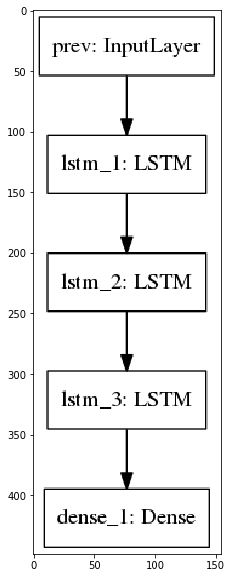

In [6]:
#Plot the model graph
from tensorflow.contrib.keras import utils

# Create model image
utils.plot_model(model, '/tmp/model.png')

# Show image
plt.imshow(plt.imread('/tmp/model.png'))


In [7]:
#Fit model
history = model.fit(X[:600000], y[:600000], batch_size=256, epochs=12,
           validation_data=(X[600000:], y[600000:]))



Train on 600000 samples, validate on 101898 samples
Epoch 1/12
600000/600000 [==============================] - 505s - loss: 2.4033 - acc: 0.2875 - val_loss: 2.0501 - val_acc: 0.3810
Epoch 2/12
600000/600000 [==============================] - 508s - loss: 1.8432 - acc: 0.4291 - val_loss: 1.7644 - val_acc: 0.4735
Epoch 3/12
600000/600000 [==============================] - 518s - loss: 1.6088 - acc: 0.4989 - val_loss: 1.6457 - val_acc: 0.5136
Epoch 4/12
600000/600000 [==============================] - 518s - loss: 1.4872 - acc: 0.5347 - val_loss: 1.5881 - val_acc: 0.5304
Epoch 5/12
600000/600000 [==============================] - 518s - loss: 1.4123 - acc: 0.5544 - val_loss: 1.5485 - val_acc: 0.5434
Epoch 6/12
600000/600000 [==============================] - 518s - loss: 1.3587 - acc: 0.5696 - val_loss: 1.5309 - val_acc: 0.5489
Epoch 7/12
600000/600000 [==============================] - 518s - loss: 1.3166 - acc: 0.5809 - val_loss: 1.5132 - val_acc: 0.5545
Epoch 8/12
600000/600000 [=====

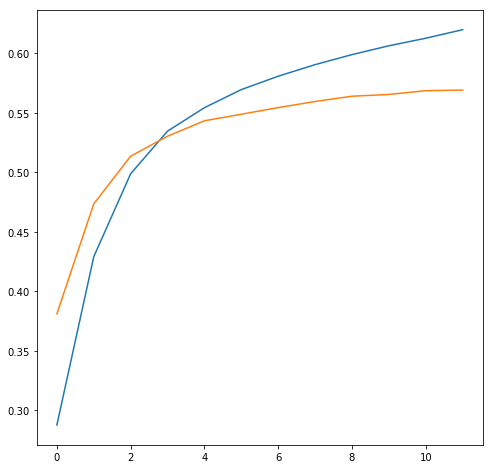

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [9]:
# Save model

models.save_model(model, path + 'models/text_generation_model1024.h5')

## Evaluate model

In [12]:
# Load model

model1 = models.load_model(path + 'models/text_generation_model1024.h5')

In [13]:
maxlen = 20


def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a), axis=0)
    a /= np.sum(a+0.0000001) #Precission error
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print()
    print('DIVERSITY: ',diversity)
    print(sentence_init + generated)


In [14]:
sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)


DIVERSITY:  0.2
mire vuestra merced a su padre, y el de la cabeza y de la mano en la cuenta de la mano en la cuerda, y el cual no le dejasen de ver en la caballeriza, y de la mano en la cabeza, y que el trabajo de la caballería de la mancha, que es tan buena como si los había para ellos que los encantadores de los malos de la mano en la cabeza, y dijo:

a lo que el duque dijo don quijote, que es la memoria de la mano en la cabeza y 


In [15]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = 'a mi señora dulcinea'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = 'el caballero andante'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



DIVERSITY:  0.2
mire vuestra merced se ha de hacer esta sazón don quijote, que es tan buen señor don quijote, y que el trabajo que estaba en el mundo de la mancha, que es tan buen señor don quijote, que es tan como el que le había de ser de la mano en la condesa y de la mano en la venta que el castillo de la mancha, que el caballero de la mano y de la mano y de la mano en la cabeza, y sin duda, que es menester un poco de la mano en 

DIVERSITY:  0.5
mire vuestra merced tan siempre en los caballeros andantes, de malda fe de ser esos años de su hija y con mucha presteza del
toboso, y que no hay más valiente que allí le están en la tierra y la mano por el de la mano en la mano de su amo que un hombre de la silla, y los presentes de los que decían.

sancho dijo don quijote, y del cual se le había dicho, y de la cual no hay para qué todo lo cual respondió don quijote

DIVERSITY:  1
mire vuestra merced por hacer dijo don quijote; porque sea alto de bendite y respondió sancho.

de los días y